We consider:

**AIS and ship variables:**

'draught','latitude','longitude','gross_tonnage' 'deadweight','length','beam','COG_cos','COG_sin','TH_cos','TH_sin','navigational_status_0.0','navigational_status_1.0',
'navigational_status_2.0','navigational_status_3.0','navigational_status_4.0','navigational_status_5.0','navigational_status_8.0','navigational_status_15.0',
' 'vessel_group_Cargo', 'vessel_group_Tanker','age,
**Feature engineering:**

'dist','efficiency','origin_lat', 'origin_lon', 'acc_dist', 'acc_time_hours',
'remaining_distance'

We don't consider: 

**AIS**

,'speed_over_ground'
'ROT_cos','ROT_sin',

**SHIP**

vessel_type_Bulk Carrier','vessel_type_Cargo/Containership','vessel_type_Chemical Tanker','vessel_type_Container Ship','vessel_type_Crude Oil Tanker','vessel_type_General Cargo',                     
'vessel_type_Heavy Load Carrier','vessel_type_LPG Tanker','vessel_type_Livestock Carrier','vessel_type_Oil Products Tanker', 'vessel_type_Oil/Chemical Tanker', 
'vessel_type_Self Discharging Bulk Carrier',

'TEU'

**Weather:**

, 'mwd', 'mwp','swh', 'swh','sst', 'utotal', 'vtotal','u10', 'v10'



















In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install neptune-client

In [ ]:
pip install neptune-tensorflow-keras

In [1]:
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from neptune.new.types import File
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Flatten
import matplotlib.pyplot as plt
import IPython 
np.set_printoptions(threshold=np.inf)

In [2]:
x_train = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/x_train.npy')
x_test = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/x_test.npy')
x_valid = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/x_valid.npy')
y_train = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/y_train.npy')
y_test = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/y_test.npy')
y_valid = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/y_valid.npy')

In [3]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1124, 65, 53)
y_train shape: (1124, 65, 1)
x_valid shape: (141, 65, 53)
y_valid shape: (141, 65, 1)
x_test shape: (140, 65, 53)
y_test shape: (140, 65, 1)


In [4]:
#removing variables
x_train= np.delete(x_train,[3,8,15,16,25,26,27,28,29,30,31,32,33,34,35,36,43,44,45,46,47,48,49,50],2)
x_test= np.delete(x_test,[3,8,15,16,25,26,27,28,29,30,31,32,33,34,35,36,43,44,45,46,47,48,49,50],2)
x_valid= np.delete(x_valid,[3,8,15,16,25,26,27,28,29,30,31,32,33,34,35,36,43,44,45,46,47,48,49,50],2)

In [5]:
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

x_train shape: (1124, 65, 29)
x_valid shape: (141, 65, 29)
x_test shape: (140, 65, 29)


In [6]:
n_features = x_train.shape[2]
steps = x_train.shape[1]
print('n_features = ', n_features)
print('steps = ', steps)

n_features =  29
steps =  65


In [7]:
run = neptune.init(project="saraelmekkaoui/JL-v1",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZGMwNTFmNS1lMTljLTQ5MGQtYTZmMi00MmVkOTQxZGNiMjUifQ==",
    tags=['CNN','allVar-AISsog-VesselType-TEU-ROT-Weather','NoSearch'], name = 'exp-49') 

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/saraelmekkaoui/JL-v1/e/JLV-91
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [8]:
def build_model():
  model = keras.Sequential()
  model.add(keras.Input(shape=(steps, n_features)))
  model.add(layers.Conv1D(filters= 64, 
                              kernel_size= 7,
                              padding='causal',
                              dilation_rate= 1, activation='relu'))
  model.add(layers.Conv1D(filters= 128, 
                              kernel_size= 5,
                              padding='causal',
                              dilation_rate= 2, activation='relu'))
  model.add(layers.Conv1D(filters= 64, 
                              kernel_size= 3,
                              padding='causal',
                              dilation_rate= 4, activation='relu'))
  model.add(layers.Dense(1, activation='relu'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-2), loss='mse', metrics=['mae','mse'])
  return model

In [9]:
model = build_model()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 65, 64)            13056     
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           41088     
                                                                 
 conv1d_2 (Conv1D)           (None, 65, 64)            24640     
                                                                 
 dense (Dense)               (None, 65, 1)             65        
                                                                 
Total params: 78,849
Trainable params: 78,849
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Build the model with the optimal hyperparameters and train it on the data for 218 epochs
model_history = model.fit(x_train, y_train, epochs= 218, batch_size=64, validation_data = (x_valid,y_valid), shuffle = False, verbose = 0)

In [12]:
model_fit_loss, model_fit_mae, model_fit_mse = model.evaluate(x_test, y_test, verbose=2)

5/5 - 0s - loss: 111.0890 - mae: 4.7930 - mse: 111.0890 - 69ms/epoch - 14ms/step


In [13]:
df_model_hist = pd.DataFrame(model_history.history)
df_model_hist['epoch'] = model_history.epoch
df_model_hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,4225.157227,45.051258,4225.156738,1228.165405,23.398293,1228.165405,0
1,658.385803,17.590324,658.385803,293.741669,12.891129,293.741669,1
2,225.241135,10.894015,225.241150,151.193161,9.063461,151.193161,2
3,158.377670,9.005063,158.377655,115.129372,7.740230,115.129364,3
4,129.688538,7.855826,129.688553,95.122581,6.766294,95.122581,4
...,...,...,...,...,...,...,...
213,28.808506,3.429273,28.808506,39.355606,3.521942,39.355610,213
214,27.867235,3.333313,27.867235,41.369736,3.676037,41.369732,214
215,24.915459,3.114323,24.915461,40.625187,3.677542,40.625183,215
216,27.287523,3.267183,27.287523,42.854473,3.912954,42.854477,216


In [14]:
run['model/model_history'].upload(File.as_html(df_model_hist))
run['model/loss'].log(model_fit_loss)
run['model/mae'].log(model_fit_mae)
run['model/mse'].log(model_fit_mse)

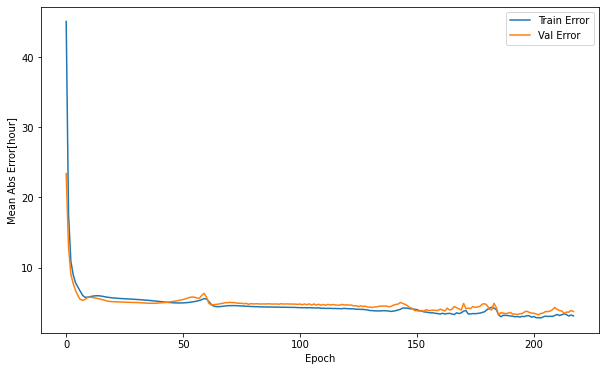

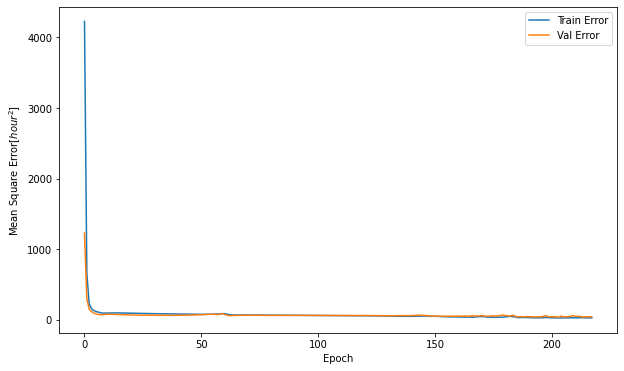

In [15]:
hist = pd.DataFrame(model_history.history)
hist['epoch'] = model_history.epoch
    
plt.figure(figsize=[10, 6])
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error[hour]')
plt.plot(hist['epoch'], hist['mae'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
plt.legend()
run['model/MAE'].log(plt.gcf())


plt.figure(figsize=[10, 6])
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error[$hour^2$]')
plt.plot(hist['epoch'], hist['mse'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
plt.legend()
run['model/MSE'].log(plt.gcf())


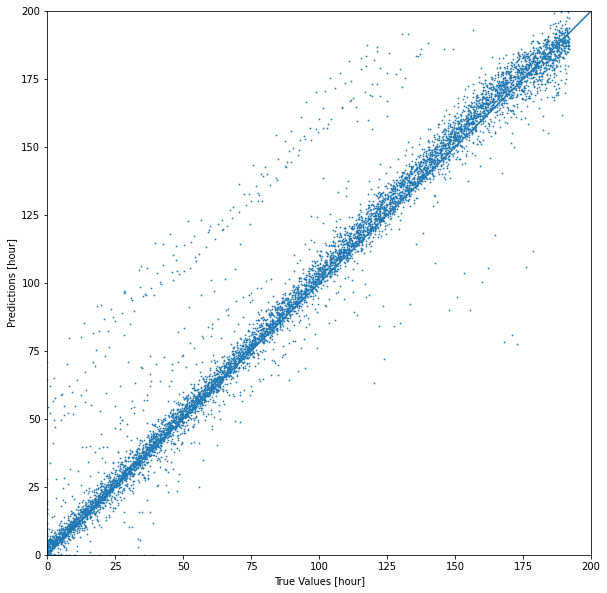

In [16]:
test_predictions = model.predict(x_test).flatten()

plt.figure(figsize=[10, 10])
a = plt.axes(aspect='equal')

plt.scatter(y_test, test_predictions,s=0.5)
plt.xlabel('True Values [hour]')
plt.ylabel('Predictions [hour]')
lims = [0, 200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

run['model/predictions_vs_target'].log(plt.gcf())   


## Model Performance
The returned MAE and MSE are calculated as the mean over 161 values of the targer. However, not all sequences are of 161 length. We hace to scale the error so that it matches the real sequence length. 

###Sequence level performance:

In [17]:
def seq_rectified_mse(x_data, y_data) :
  MSE =[]
  seq_len = []
  for i in range(x_data.shape[0]):
    x = x_data[i]
    y = y_data[i]
    x = x.reshape(1,steps,n_features)
    y = y.reshape(1,steps,1)
    s = np.sum(x, axis = -1)
    z = np.count_nonzero(s)
    y_hat = model.predict(x)
    error = np.mean(np.square(y[:,:z,:] - y_hat[:,:z,:]))
    MSE.append(error)
    seq_len.append(z)
  return np.mean(MSE), MSE, seq_len

In [18]:
seq_rect_mse_el = seq_rectified_mse(x_test, y_test)

In [19]:
seq_rect_mse = seq_rect_mse_el[0]
seq_rect_mse

180.54648317489125

In [20]:
seq_rect_mse_list = seq_rect_mse_el[1]
seq_rect_mse_len = seq_rect_mse_el[2]

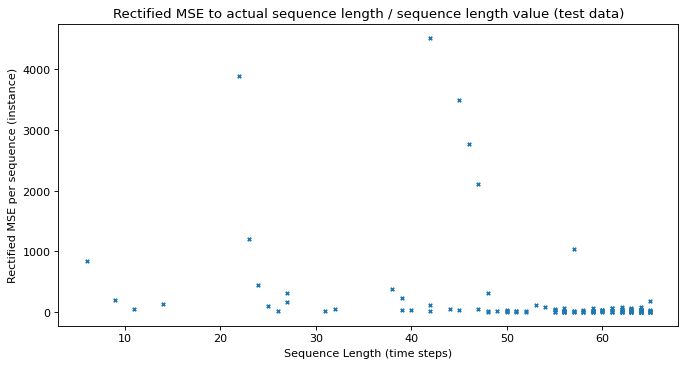

In [21]:
plt.figure(figsize=[10, 5],dpi= 80)
plt.scatter(seq_rect_mse_len, seq_rect_mse_list,s=10, marker='x')
plt.xlabel('Sequence Length (time steps)')
plt.ylabel('Rectified MSE per sequence (instance)')
plt.title('Rectified MSE to actual sequence length / sequence length value (test data)')
run['model/seq_rectified_mse/seq_rect_mse_plot'].log(plt.gcf())  

In [22]:
rect_mse_high_val_indices = [i for i, x in enumerate(seq_rect_mse_list) if x > 2000]
rect_mse_high_val_indices 

[99, 105, 112, 130, 137]

In [23]:
rect_mse_high_val = [seq_rect_mse_list[i] for i in rect_mse_high_val_indices]
rect_mse_high_val

[2109.476751150317,
 4522.233520347645,
 3490.4737321544735,
 3885.630936069989,
 2767.6866271882973]

In [24]:
rect_mse_high_val_seq_len = [seq_rect_mse_len[i] for i in rect_mse_high_val_indices]
rect_mse_high_val_seq_len 

[47, 42, 45, 22, 46]

In [25]:
run['model/seq_rectified_mse/mse'].log(seq_rect_mse)
run['model/seq_rectified_mse/mse_list'].log(seq_rect_mse_list)
run['model/seq_rectified_mse/mse_seq_lengths'].log(seq_rect_mse_len)
run['model/seq_rectified_mse/high_mse_indices'].log(rect_mse_high_val_indices)
run['model/seq_rectified_mse/high_mse'].log(rect_mse_high_val)
run['model/seq_rectified_mse/high_mse_seq_lengths'].log(rect_mse_high_val_seq_len )

In [26]:
def seq_rectified_mae(x_data, y_data) :
  MAE =[]
  seq_len = []
  for i in range(x_data.shape[0]):
    x = x_data[i]
    y = y_data[i]
    x = x.reshape(1,steps,n_features)
    y = y.reshape(1,steps,1)
    s = np.sum(x, axis = -1)
    z = np.count_nonzero(s)
    y_hat = model.predict(x)
    error = np.mean(np.abs(y[:,:z,:] - y_hat[:,:z,:]))
    MAE.append(error)
    seq_len.append(z)
  return np.mean(MAE), MAE, seq_len

In [27]:
seq_rect_mae_el = seq_rectified_mae(x_test, y_test)

In [28]:
seq_rect_mae = seq_rect_mae_el[0]
seq_rect_mae

6.713813655637845

In [29]:
seq_rect_mae_list = seq_rect_mae_el [1]
seq_rect_mae_len = seq_rect_mae_el[2]

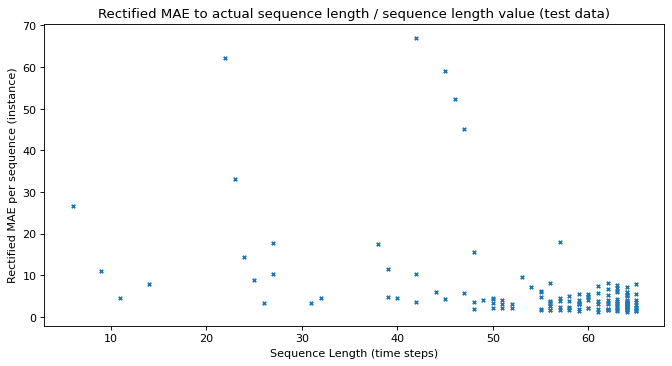

In [30]:
plt.figure(figsize=[10, 5],dpi= 80)
plt.scatter(seq_rect_mae_len, seq_rect_mae_list,s=10, marker='x')
plt.xlabel('Sequence Length (time steps)')
plt.ylabel('Rectified MAE per sequence (instance)')
plt.title('Rectified MAE to actual sequence length / sequence length value (test data)')
run['model/seq_rectified_mae/seq_rect_mae_plot'].log(plt.gcf()) 

In [31]:
rect_mae_high_val_indices = [i for i, x in enumerate(seq_rect_mae_list) if x > 40]
rect_mae_high_val_indices 

[99, 105, 112, 130, 137]

In [32]:
rect_mae_high_val = [seq_rect_mae_list[i] for i in rect_mae_high_val_indices]
rect_mae_high_val

[45.05340258118109,
 67.072095870568,
 58.99510893079969,
 62.16633500301476,
 52.398383496049526]

In [33]:
rect_mae_high_val_seq_len = [seq_rect_mae_len[i] for i in rect_mae_high_val_indices]
rect_mae_high_val_seq_len 

[47, 42, 45, 22, 46]

In [34]:
run['model/seq_rectified_mae/mae'].log(seq_rect_mse)
run['model/seq_rectified_mae/mae_list'].log(seq_rect_mse_list)
run['model/seq_rectified_mae/mae_seq_lengths'].log(seq_rect_mse_len)
run['model/seq_rectified_mae/high_mae_indices'].log(rect_mse_high_val_indices)
run['model/seq_rectified_mae/high_mae'].log(rect_mse_high_val)
run['model/seq_rectified_mae/high_mae_seq_lengths'].log(rect_mse_high_val_seq_len )

In [35]:
run['model/corrected_MSE'].log(seq_rect_mse)
run['model/corrected_MAE'].log(seq_rect_mae)

###Instance level performance:

In [36]:
#mean and standard deviation of the 'remaining distance' variable to inverse standardized values  
u = 679.52
s = 625.47

In [40]:
def inst_mse(x_data, y_data) :
  MSE =[]
  distance = []
  for i in range(x_data.shape[0]):
    x = x_data[i]
    y = y_data[i]
    x = x.reshape(1,steps,n_features)
    y = y.reshape(1,steps,1)
    s = np.sum(x, axis = -1)
    z = np.count_nonzero(s)
    y_hat = model.predict(x)
    error = np.square(y[:,:z,:] - y_hat[:,:z,:])
    error = error.reshape(z)
    error = error.tolist()
    MSE.extend(error)
    #dist = d[i,:z]
    dist = x[:,:z,-1].reshape(z)
    dist = dist.tolist()
    distance.extend(dist)
  return np.mean(MSE), MSE, distance

In [41]:
def inst_mae(x_data, y_data) :
  MAE =[]
  distance = []
  for i in range(x_data.shape[0]):
    x = x_data[i]
    y = y_data[i]
    x = x.reshape(1,steps,n_features)
    y = y.reshape(1,steps,1)
    s = np.sum(x, axis = -1)
    z = np.count_nonzero(s)
    y_hat = model.predict(x)
    error = np.abs(y[:,:z,:] - y_hat[:,:z,:])
    error = error.reshape(z)
    error = error.tolist()
    MAE.extend(error)
    #dist = d[i,:z]
    dist = x[:,:z,-1].reshape(z)
    dist = dist.tolist()
    distance.extend(dist)
  return np.mean(MAE), MAE, distance

In [39]:
#as we are not using the 'remaining distance' variable we have to import it from the test dataset to use it in this section
#x_full = np.load('/content/drive/MyDrive/ETA_Project/JL_V1/Datasets/Incl_Weather/JL_V1_Weather_Seq_Pad_wo_Emb/x_test.npy')

In [ ]:
#traj = x_full[:,:,-1]

In [42]:
inst_mae_el = inst_mae(x_test, y_test)

In [43]:
inst_mae = inst_mae_el[0]
inst_mae

5.634775599713934

In [44]:
inst_mae_list = inst_mae_el[1]
inst_mae_distance = inst_mae_el[2]

In [45]:
inst_mae_dist_reverse = [(item*s)+u for item in inst_mae_distance]

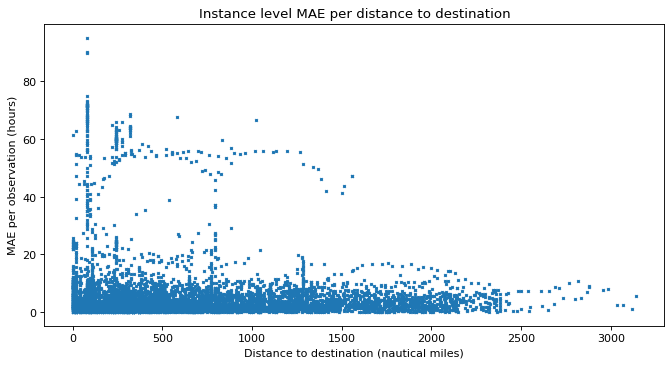

In [46]:
plt.figure(figsize=[10, 5],dpi= 80)

plt.scatter(inst_mae_dist_reverse, inst_mae_list,s=5, marker='x')
plt.xlabel('Distance to destination (nautical miles)')
plt.ylabel('MAE per observation (hours)')
plt.title('Instance level MAE per distance to destination')
run['model/instance_mae/inst_mae_dist_plot'].log(plt.gcf()) 

In [47]:
run['model/instance_mae/mae'].log(inst_mae)
run['model/instance_mae/inst_mae_list'].log(inst_mae_list)
run['model/instance_mae/inst_mae_distance'].log(inst_mae_distance)

In [48]:
inst_mse_el = inst_mse(x_test, y_test)

In [49]:
inst_mse = inst_mse_el[0]
inst_mse

130.3226596696949

In [50]:
inst_mse_list = inst_mse_el[1]
inst_mse_distance = inst_mse_el[2]

In [51]:
inst_mse_dist_reverse = [(item*s)+u for item in inst_mse_distance]

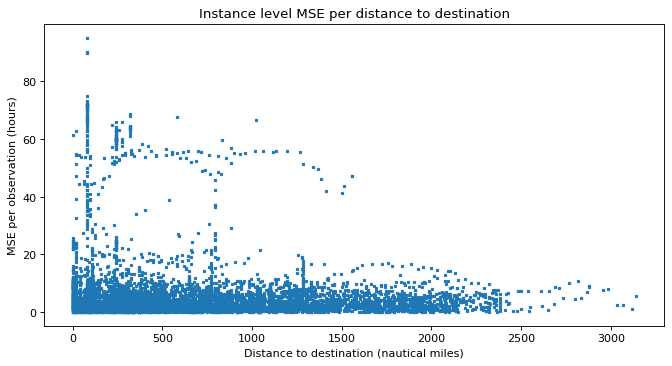

In [52]:
plt.figure(figsize=[10, 5],dpi= 80)

plt.scatter(inst_mae_dist_reverse, inst_mae_list,s=5, marker='x')
plt.xlabel('Distance to destination (nautical miles)')
plt.ylabel('MSE per observation (hours)')
plt.title('Instance level MSE per distance to destination')
run['model/instance_mse/inst_mse_dist_plot'].log(plt.gcf()) 

In [53]:
run['model/instance_mse/mse'].log(inst_mse)
run['model/instance_mse/inst_mse_list'].log(inst_mse_list)
run['model/instance_mse/inst_mse_distance'].log(inst_mse_distance)

In [54]:
model.save('/content/drive/MyDrive/ETA_Project/JL_V1/Notebooks/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ETA_Project/JL_V1/Notebooks/model/assets


In [55]:
run['model/trained_model'].upload('/content/drive/MyDrive/ETA_Project/JL_V1/Notebooks/model/saved_model.pb')

In [56]:
run['Notebook'].upload('/content/drive/MyDrive/ETA_Project/JL_V1/Notebooks/JL_V1_ETA_CNN_V1.ipynb')

In [ ]:
run.stop()